In [1]:
!pip install kaggle
!kaggle datasets download -d moltean/fruits
#!unzip fruits.zip -d fruits360

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Veri klasörünü tanımlama
train_dir = "fruits360/fruits-360_dataset_100x100/fruits-360/Training"
test_dir = "fruits360/fruits-360_dataset_100x100/fruits-360/Test"

In [3]:
import tensorflow as tf

# GPU cihazlarını listele ve bellek büyümesini ayarla
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth is set.")
    except RuntimeError as e:
        print("Memory growth must be set before GPUs are initialized:", e)
else:
    print("No GPU found.")


2024-12-20 13:46:29.571325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734691589.626823    7811 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734691589.643830    7811 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:46:29.768190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU memory growth is set.


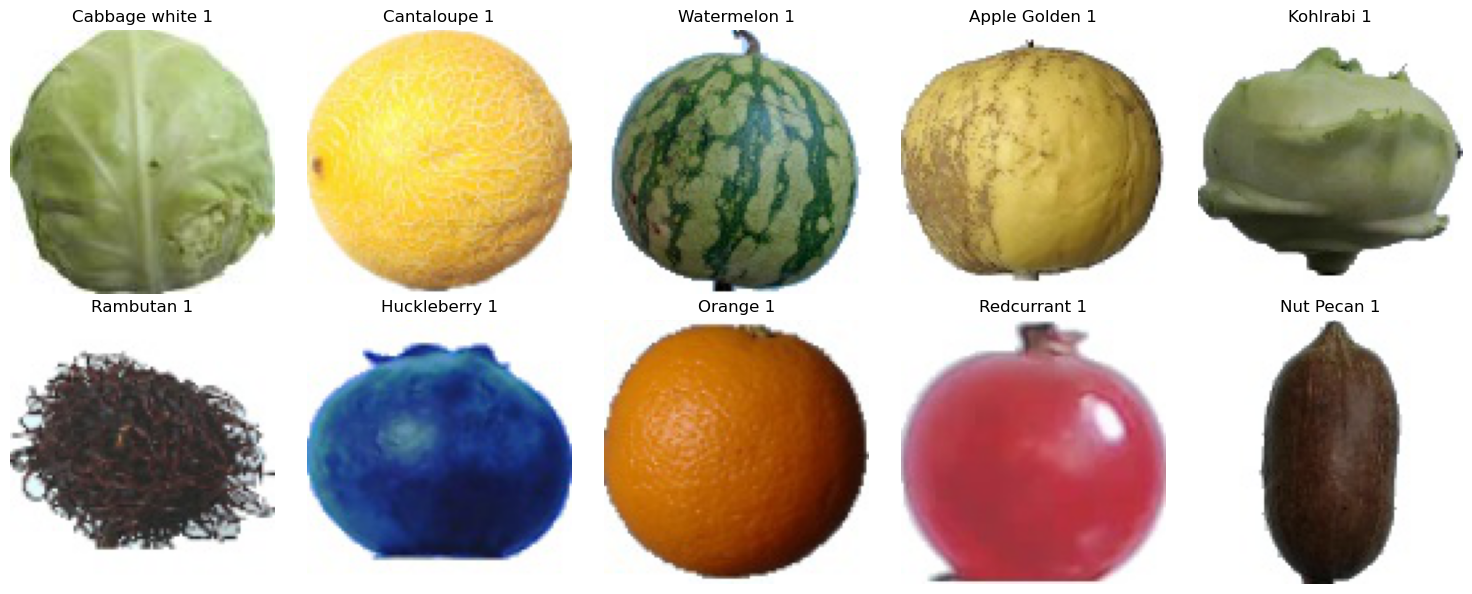

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fruit_classes = os.listdir(train_dir)[:10]  # İlk 10 sınıfı göster

for i, fruit in enumerate(fruit_classes):
    fruit_folder = os.path.join(train_dir, fruit)
    fruit_image = os.listdir(fruit_folder)[0]  # İlk resmi al
    img_path = os.path.join(fruit_folder, fruit_image)
    img = Image.open(img_path)
    
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_title(fruit)

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma tanımı
datagen = ImageDataGenerator(
    rescale=1./255,        # Piksel değerlerini normalize eder
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Eğitim ve test veri setleri
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse'
)

Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Veri setini yükleme ve ön işleme
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(100, 100), batch_size=32)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(100, 100), batch_size=32)

# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# EarlyStopping ve ReduceLROnPlateau callback'leri
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_generator, epochs=25, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])


Found 70491 files belonging to 141 classes.
Found 23619 files belonging to 141 classes.
Epoch 1/25


/home/kubilaybey/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2203/2203 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1819 - loss: 3.5745  

/home/kubilaybey/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2203/2203 ━━━━━━━━━━━━━━━━━━━━ 186s 83ms/step - accuracy: 0.1820 - loss: 3.5741 - val_accuracy: 0.7285 - val_loss: 1.1988 - learning_rate: 0.0010
Epoch 2/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 183s 83ms/step - accuracy: 0.5678 - loss: 1.5910 - val_accuracy: 0.7803 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 3/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - accuracy: 0.6251 - loss: 1.4050 - val_accuracy: 0.8393 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 4/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 182s 82ms/step - accuracy: 0.6580 - loss: 1.3102 - val_accuracy: 0.8630 - val_loss: 0.7653 - learning_rate: 0.0010
Epoch 5/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 180s 82ms/step - accuracy: 0.6809 - loss: 1.2459 - val_accuracy: 0.8542 - val_loss: 0.7649 - learning_rate: 0.0010
Epoch 6/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 186s 84ms/step - accuracy: 0.7028 - loss: 1.1960 - val_accuracy: 0.8938 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 7/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - accuracy: 

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test doğruluğu: {test_accuracy:.4f}")
print(f"Test kaybı: {test_loss:.4f}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9560 - loss: 0.3563
Test doğruluğu: 0.9584
Test kaybı: 0.3559


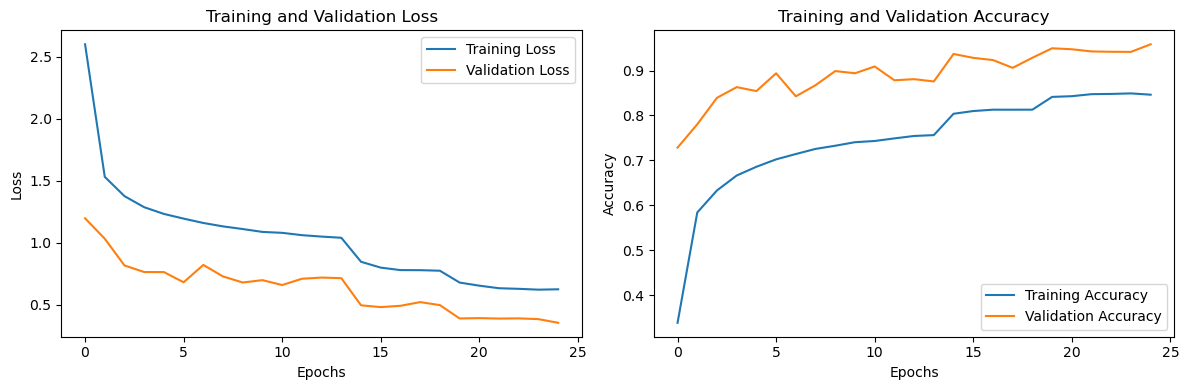

In [22]:
# Eğitim ve doğrulama loss grafiği
plt.figure(figsize=(12, 4))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model TFLite formatında kaydedildi!")

INFO:tensorflow:Assets written to: /tmp/tmpam8xtjuw/assets


INFO:tensorflow:Assets written to: /tmp/tmpam8xtjuw/assets


Saved artifact at '/tmp/tmpam8xtjuw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 141), dtype=tf.float32, name=None)
Captures:
  129873401343312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129873401342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129873401332944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129873401342544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129873401342736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129871507821136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129871507821328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129871507821904: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1734697317.743414    7811 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734697317.743428    7811 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-20 15:21:57.743769: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpam8xtjuw
2024-12-20 15:21:57.744499: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-20 15:21:57.744511: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpam8xtjuw
I0000 00:00:1734697317.750249    7811 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-12-20 15:21:57.751386: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-20 15:21:57.804466: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpam8xtjuw
2024-12-20 15:21:57.815337: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model TFLite formatında kaydedildi!
